In [1]:
%matplotlib inline

In [29]:
#export
from exp.nb_04 import *

from functools import partial

## Data Setup

In [5]:
xTraining, yTraining, xValidation, yValidation = getMnistData()
xTrainingNormalized = normalizeVector(xTraining, xTraining.mean(),xTraining.std())
xValidationNormalized = normalizeVector(xValidation, xValidation.mean(),xValidation.std())

In [7]:
xTrainingNormalized.mean(), xTrainingNormalized.std()

(tensor(-7.6999e-06), tensor(1.))

In [8]:
xValidation.mean(), xValidation.std()

(tensor(0.1287), tensor(0.3050))

In [9]:
batchSize = 64

In [10]:
trainingDataSet = Dataset(xTrainingNormalized, yTraining)
validationDataSet = Dataset(xValidationNormalized, yValidation)

In [12]:
trainingDataLoader, validationDataLoader = createDataLoaders(trainingDataSet, validationDataSet, batchSize)

In [13]:
imageDataBunch = DataBunch(trainingDataLoader, validationDataLoader)

In [16]:
numberOfImages, numberOfPixels = xTrainingNormalized.shape
hiddenLayerSize = 50
numberOfClasses = yTraining.max().item() + 1

In [20]:
def createCNNModel(): return CNNModel(numberOfPixels, 
                   hiddenLayerSize, 
                   numberOfClasses)

In [25]:
cnnModel = createCNNModel()
cnnModel

CNNModel(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

### Scheduling

The process of adjusting the learning rate as model training moves forward.

In [26]:
#export
def FixedRange(schedulingFunction):
    def _fixedScheduler(start, end): return partial(schedulingFunction, start, end)
    return _fixedScheduler

In [27]:
# Creates a learning rate that will follow a linear path.

@FixedRange
def linearScheduler(start, end, timePosition): return start + timePosition * (end - start)

In [44]:
# Fix the linear scheduler to a specified range
fixedScheduler = linearScheduler(1,4) # essentially first argument is b and m in the equation y=mx+b
fixedScheduler

functools.partial(<function linearScheduler at 0x1a2c285840>, 1, 4)

In [45]:
fixedScheduler(0), \
fixedScheduler(1), \
fixedScheduler(2)

(1, 4, 7)

In [46]:
@FixedRange
def cosineScheduler(start, end, timePosition): return start + (1 + math.cos(math.pi*(1-timePosition))) * (end-start) / 2

@FixedRange
def constantScheduler(start, end, timePosition): return start

@FixedRange
def exponentialScheduler(start, end, timePosition): return start * (end / start)**timePosition


In [48]:
#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

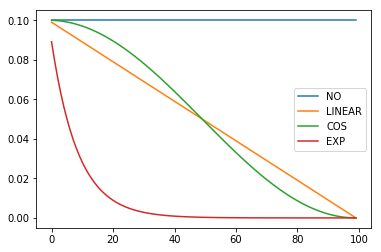

In [101]:
annealings = "NO LINEAR COS EXP".split()

steps = torch.arange(0, 100)
inputSpace = torch.linspace(0.01,1,100)

schedulers = [constantScheduler, linearScheduler, cosineScheduler, exponentialScheduler]
for scheduler, label in zip(schedulers, annealings):
    fixedScheduler = scheduler(1e-1,1e-6)
    plotter.plot(steps, [fixedScheduler(o) for o in inputSpace], label=label)
plotter.legend();

In [53]:
#export
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [73]:
#export
def aggregateSchedulers(appliedPercentages, schedulers):
    assert sum(appliedPercentages) == 1
    percentages = tensor([0] + listify(appliedPercentages))
    assert torch.all(percentages >= 0)
    percentages = torch.cumsum(percentages, 0) # each vector component is the aggregation of it and the one before it
    def _inner(timePosition):
        currentIndex = (timePosition >= percentages).nonzero().max()
        actualPosition = (timePosition-percentages[currentIndex]) / (percentages[currentIndex+1]-percentages[currentIndex])
        return schedulers[currentIndex](actualPosition)
    return _inner

In [92]:
aggregatedScheduler = aggregateSchedulers([0.3, 0.7], [cosineScheduler(0.3, 0.6), cosineScheduler(0.6, 0.1)])

In [97]:
inputSpace[:5]

tensor([0.0100, 0.0200, 0.0300, 0.0400, 0.0500])

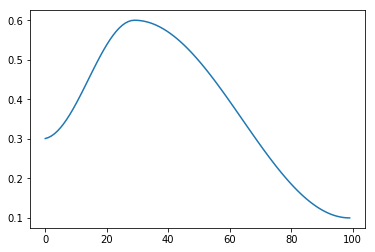

In [98]:
plotter.plot(steps, [aggregatedScheduler(o) for o in inputSpace])

In [158]:
#export
def createCosineScheduler(start, high, end):
    return [cosineScheduler(start, high), cosineScheduler(high, end)]

In [160]:
phases = [0.3, 0.7]
weightsScheduler = aggregateSchedulers(phases, createCosineScheduler(0.3, 0.6, 0.2)) 
biasScheduler = aggregateSchedulers(phases, createCosineScheduler(0.9, 1.8, 0.6))

In [164]:
class TeacherWithAnnealing():
    
    def __init__(self, 
                 lossFunction=Functional.cross_entropy, 
                 accuracyFunction=accuracy,
                 schedulingFunctions=[cosineScheduler(1e-1,1e-6), cosineScheduler(1e-1,1e-6)]
                ):
        self.lossFunction = lossFunction
        self.accuracyFunction = accuracyFunction
        self.schedulingFunctions = schedulingFunctions
        self._initStorage()

    def _initStorage(self):
        self.learningRates, self.losses = [],[]
        
    def teachModel(self, cnnModel, dataBunch, numberOfEpochs):
        self.optimizer = optim.SGD(cnnModel.parameters(), self.schedulingFunctions[0](0))
        self.numberOfEpochs = numberOfEpochs
        self._beginTraining()
        for epoch in range(numberOfEpochs):
            self.epoch = epoch
            trainingLoss, trainingAccuracy = self._trainModel(cnnModel, dataBunch.trainingDataLoader)
            print("Epoch #{} Training: Loss {} Accuracy {}".format(epoch, trainingLoss, trainingAccuracy))
            
            validationLoss, validationAccuracy = self._validateModel(cnnModel, dataBunch.validationDataLoader)
            print("Epoch #{} Validation: Loss {} Accuracy {}".format(epoch, validationLoss, validationAccuracy))
            print("")
            
    def plotLearningRates  (self): plotter.plot(self.learningRates)
        
    def plotLosses(self): plotter.plot(self.losses)
            
    def _beginTraining(self):
        self._initStorage()
            
    def _anealLearningRate(self):
        for parameterGroup, schedulingFunction in zip(self.optimizer.param_groups,self.schedulingFunctions):
            scheduledLearningRate = schedulingFunction(self.epoch/self.numberOfEpochs)
            parameterGroup['lr'] = scheduledLearningRate
            
    def _trainModel(self, cnnModel, trainingDataSet):
        def _teachModel(loss):
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            #capture metrics
            self.learningRates.append(self.optimizer.param_groups[-1]['lr'])
            self.losses.append(loss.detach().cpu())
            
        returnItems = self._proccessDataSet(cnnModel, trainingDataSet, self._anealLearningRate, _teachModel)
        return returnItems
        
    def _validateModel(self, cnnModel, validationDataSet):
        with torch.no_grad():
            returnItems = self._proccessDataSet(cnnModel, validationDataSet, self._anealLearningRate)
        return returnItems
    
    def _proccessDataSet(self, 
                         cnnModel, 
                         dataLoader, 
                         preEvaluation=lambda: None,
                         postEvaluation=lambda loss: None):
        accumulatedLoss, accumulatedAccuracy = 0.,0.
        for _xDataSet, _yDataSet in dataLoader:
            preEvaluation()
            _predictions = cnnModel(_xDataSet)
            loss = self.lossFunction(_predictions, _yDataSet)
            postEvaluation(loss)
            accumulatedLoss+= loss
            accumulatedAccuracy += self.accuracyFunction(_predictions, _yDataSet)
        numberOfBatches = len(dataLoader)
        return accumulatedLoss/numberOfBatches, accumulatedAccuracy/numberOfBatches


In [165]:
cnnModel = CNNModel(numberOfPixels, hiddenLayerSize, numberOfClasses)
cnnModel

CNNModel(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [167]:
annealedTeacher = TeacherWithAnnealing(schedulingFunctions=[weightsScheduler, biasScheduler])

In [168]:
accuracy(cnnModel(xValidationNormalized), yValidation)

tensor(0.1117)

In [169]:
annealedTeacher.teachModel(cnnModel, imageDataBunch, 9)

Epoch #0 Training: Loss 0.28139644861221313 Accuracy 0.9132233262062073
Epoch #0 Validation: Loss 0.15825869143009186 Accuracy 0.9515427350997925

Epoch #1 Training: Loss 0.16978707909584045 Accuracy 0.9492087364196777
Epoch #1 Validation: Loss 1.0113630294799805 Accuracy 0.817147970199585

Epoch #2 Training: Loss 0.21822597086429596 Accuracy 0.9411764740943909
Epoch #2 Validation: Loss 0.19879083335399628 Accuracy 0.9552017450332642

Epoch #3 Training: Loss 0.18957401812076569 Accuracy 0.9505874514579773
Epoch #3 Validation: Loss 0.5188460350036621 Accuracy 0.8927017450332642

Epoch #4 Training: Loss 0.14917892217636108 Accuracy 0.9593390226364136
Epoch #4 Validation: Loss 0.1439983993768692 Accuracy 0.9644976258277893

Epoch #5 Training: Loss 0.11289297044277191 Accuracy 0.9683703780174255
Epoch #5 Validation: Loss 0.22703318297863007 Accuracy 0.9527294039726257

Epoch #6 Training: Loss 0.07423990219831467 Accuracy 0.9778412580490112
Epoch #6 Validation: Loss 0.14581964910030365 Accu

In [170]:
accuracy(cnnModel(xValidationNormalized), yValidation)

tensor(0.9739)

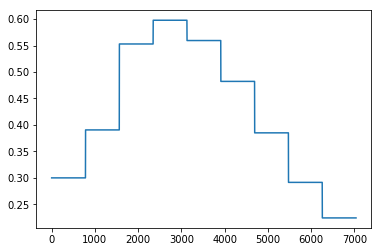

In [171]:
annealedTeacher.plotLearningRates()

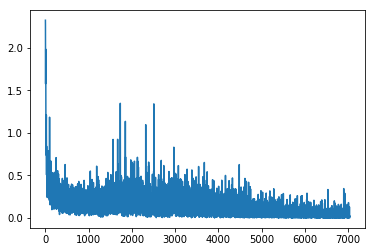

In [172]:
annealedTeacher.plotLosses()